In [199]:
import time
start_time = time.time()

In [200]:
import pandas as pd
import collections
from functools import reduce

import sqlalchemy as salc
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


with open("/Users/pvuda/Development/il_ai_creds.json") as config_file:
    config = json.load(config_file)

In [201]:
from sqlalchemy import create_engine, text

database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

connection_string = database_connection_string
engine = create_engine(connection_string)

In [202]:
f = open('ai_repos.json')
data = json.load(f)
f.close()

repo_git_set = []
repo_git_set = data.get('math')

# for key in data.keys():
#     repo_git_set.extend(data.get(key))
# repo_git_set



In [1]:
repo_set = []
repo_name_set = []

for repo_git in repo_git_set:
    repo_query = text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = \'{repo_git}\'
            """)

    # Using the connection to execute the query
    with engine.connect() as connection:
        t = connection.execute(repo_query)
        results = t.mappings().all()
        if results:
            repo_id = results[0]['repo_id']
            repo_name = results[0]['repo_name']
        else:
            repo_id = None
            repo_name = None
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)

print(repo_set)
print(repo_name_set)


NameError: name 'repo_git_set' is not defined

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [204]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_name,
                r.repo_git,
                i.cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = \'{repo_id}\' AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'issue_id']
display(issue_contrib)
issue_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,issue_id
0,25495,numpy,https://github.com/numpy/numpy,None,52674
1,25495,numpy,https://github.com/numpy/numpy,None,52675
2,25495,numpy,https://github.com/numpy/numpy,None,48717
3,25495,numpy,https://github.com/numpy/numpy,None,45286
4,25495,numpy,https://github.com/numpy/numpy,None,43800
...,...,...,...,...,...
153342,25499,mlx,https://github.com/ml-explore/mlx,None,36286
153343,25499,mlx,https://github.com/ml-explore/mlx,None,36287
153344,25499,mlx,https://github.com/ml-explore/mlx,None,36288
153345,25499,mlx,https://github.com/ml-explore/mlx,None,35956


repo_id       int64
repo_name    object
repo_git     object
cntrb_id     object
issue_id      int64
dtype: object

### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [205]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        prm.cntrb_id,
                        prm.pull_request_id
                    FROM
                        repo r, pull_request_meta prm
                    WHERE
                        prm.repo_id = \'{repo_id}\' AND
                        prm.repo_id = r.repo_id
                    LIMIT 50000
                """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']
display(pr_contrib)
pr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,269835
1,25495,numpy,https://github.com/numpy/numpy,01000050-5800-0000-0000-000000000000,269836
2,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,269836
3,25495,numpy,https://github.com/numpy/numpy,0100054a-1800-0000-0000-000000000000,269837
4,25495,numpy,https://github.com/numpy/numpy,01000466-1400-0000-0000-000000000000,269837
...,...,...,...,...,...
250073,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,40855
250074,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,40855
250075,25499,mlx,https://github.com/ml-explore/mlx,0100a3b8-0700-0000-0000-000000000000,40862
250076,25499,mlx,https://github.com/ml-explore/mlx,01062118-7200-0000-0000-000000000000,40862


repo_id             int64
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id     int64
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [206]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        prr.cntrb_id,
                        prr.pull_request_id
                    FROM
                        repo r, pull_request_reviews prr
                    WHERE
                        prr.repo_id = \'{repo_id}\' AND
                        prr.repo_id = r.repo_id
                """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']
display(prr_contrib)
prr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62697
1,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62681
2,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62586
3,25500,keras-io,https://github.com/keras-team/keras-io,01001535-7100-0000-0000-000000000000,62486
4,25500,keras-io,https://github.com/keras-team/keras-io,01000ad6-6f00-0000-0000-000000000000,62386
...,...,...,...,...,...
2156,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41463
2157,25499,mlx,https://github.com/ml-explore/mlx,01008439-5300-0000-0000-000000000000,41391
2158,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41324
2159,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41250


repo_id            object
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [207]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    if not repo_id:
        continue
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        ca.cntrb_id,
                        c.cmt_id
                    FROM
                        repo r, commits c, contributors_aliases ca
                    WHERE
                        c.repo_id = \'{repo_id}\' AND
                        c.repo_id = r.repo_id and
                        c.cmt_committer_email = ca.alias_email
                """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'cmt_id']
display(commit_contrib)
commit_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,cmt_id
0,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,505655
1,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,505656
2,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401510
3,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401511
4,25495,numpy,https://github.com/numpy/numpy,01005529-0a00-0000-0000-000000000000,401512
...,...,...,...,...,...
2036021,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,73753
2036022,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,76384
2036023,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,76385
2036024,25499,mlx,https://github.com/ml-explore/mlx,01012f1b-7f00-0000-0000-000000000000,76386


repo_id       int64
repo_name    object
repo_git     object
cntrb_id     object
cmt_id        int64
dtype: object

## Projects and Contributors as Nodes

### Commit Contributor Graph

In [208]:
df_commit = commit_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,01000010-bb00-0000-0000-000000000000,...,01088669-8300-0000-0000-000000000000,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,0,0,0,0,0,0,0,26,0,...,0,0,0,0,0,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
numpy,0,0,0,1,0,0,0,0,0,0,...,2,0,0,5,0,3,0,0,0,0


In [209]:
df_commit = df_commit.reset_index()
df_commit.head()

cntrb_id,repo_name,01000002-5600-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-0900-0000-0000-000000000000,01000009-ae00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,0100000a-ae00-0000-0000-000000000000,0100000f-7700-0000-0000-000000000000,...,01088669-8300-0000-0000-000000000000,0108a5b7-ff00-0000-0000-000000000000,0108a6f1-9e00-0000-0000-000000000000,0108c567-ba00-0000-0000-000000000000,0108eb97-de00-0000-0000-000000000000,01091e7c-1b00-0000-0000-000000000000,0109ff1f-4600-0000-0000-000000000000,010a36e9-1e00-0000-0000-000000000000,010a42c5-1000-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
0,arrow,0,0,0,0,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
1,keras-io,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,mlx,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,networkx,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,numpy,0,0,0,1,0,0,0,0,0,...,2,0,0,5,0,3,0,0,0,0


In [210]:
df_melted_commit = df_commit.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [211]:
df_melted_commit

,repo_name,cntrb_id,number
0,arrow,01000002-5600-0000-0000-000000000000,0
1,keras-io,01000002-5600-0000-0000-000000000000,0
2,mlx,01000002-5600-0000-0000-000000000000,0
3,networkx,01000002-5600-0000-0000-000000000000,0
4,numpy,01000002-5600-0000-0000-000000000000,0
...,...,...,...
36795,pandas,010a45e6-4c00-0000-0000-000000000000,0
36796,polaris,010a45e6-4c00-0000-0000-000000000000,304
36797,pytorch,010a45e6-4c00-0000-0000-000000000000,0
36798,tensorflow,010a45e6-4c00-0000-0000-000000000000,0


In [212]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

,repo_name,cntrb_id,number
8,tensorflow,01000002-5600-0000-0000-000000000000,1
13,networkx,01000004-ca00-0000-0000-000000000000,1
28,tensorflow,01000006-8000-0000-0000-000000000000,1
34,numpy,01000007-8900-0000-0000-000000000000,1
48,tensorflow,01000009-0900-0000-0000-000000000000,12


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

In [213]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [214]:
nodes = G.nodes()
Repo_id = df_melted_commit['repo_name'].to_list()
contributor_id = df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

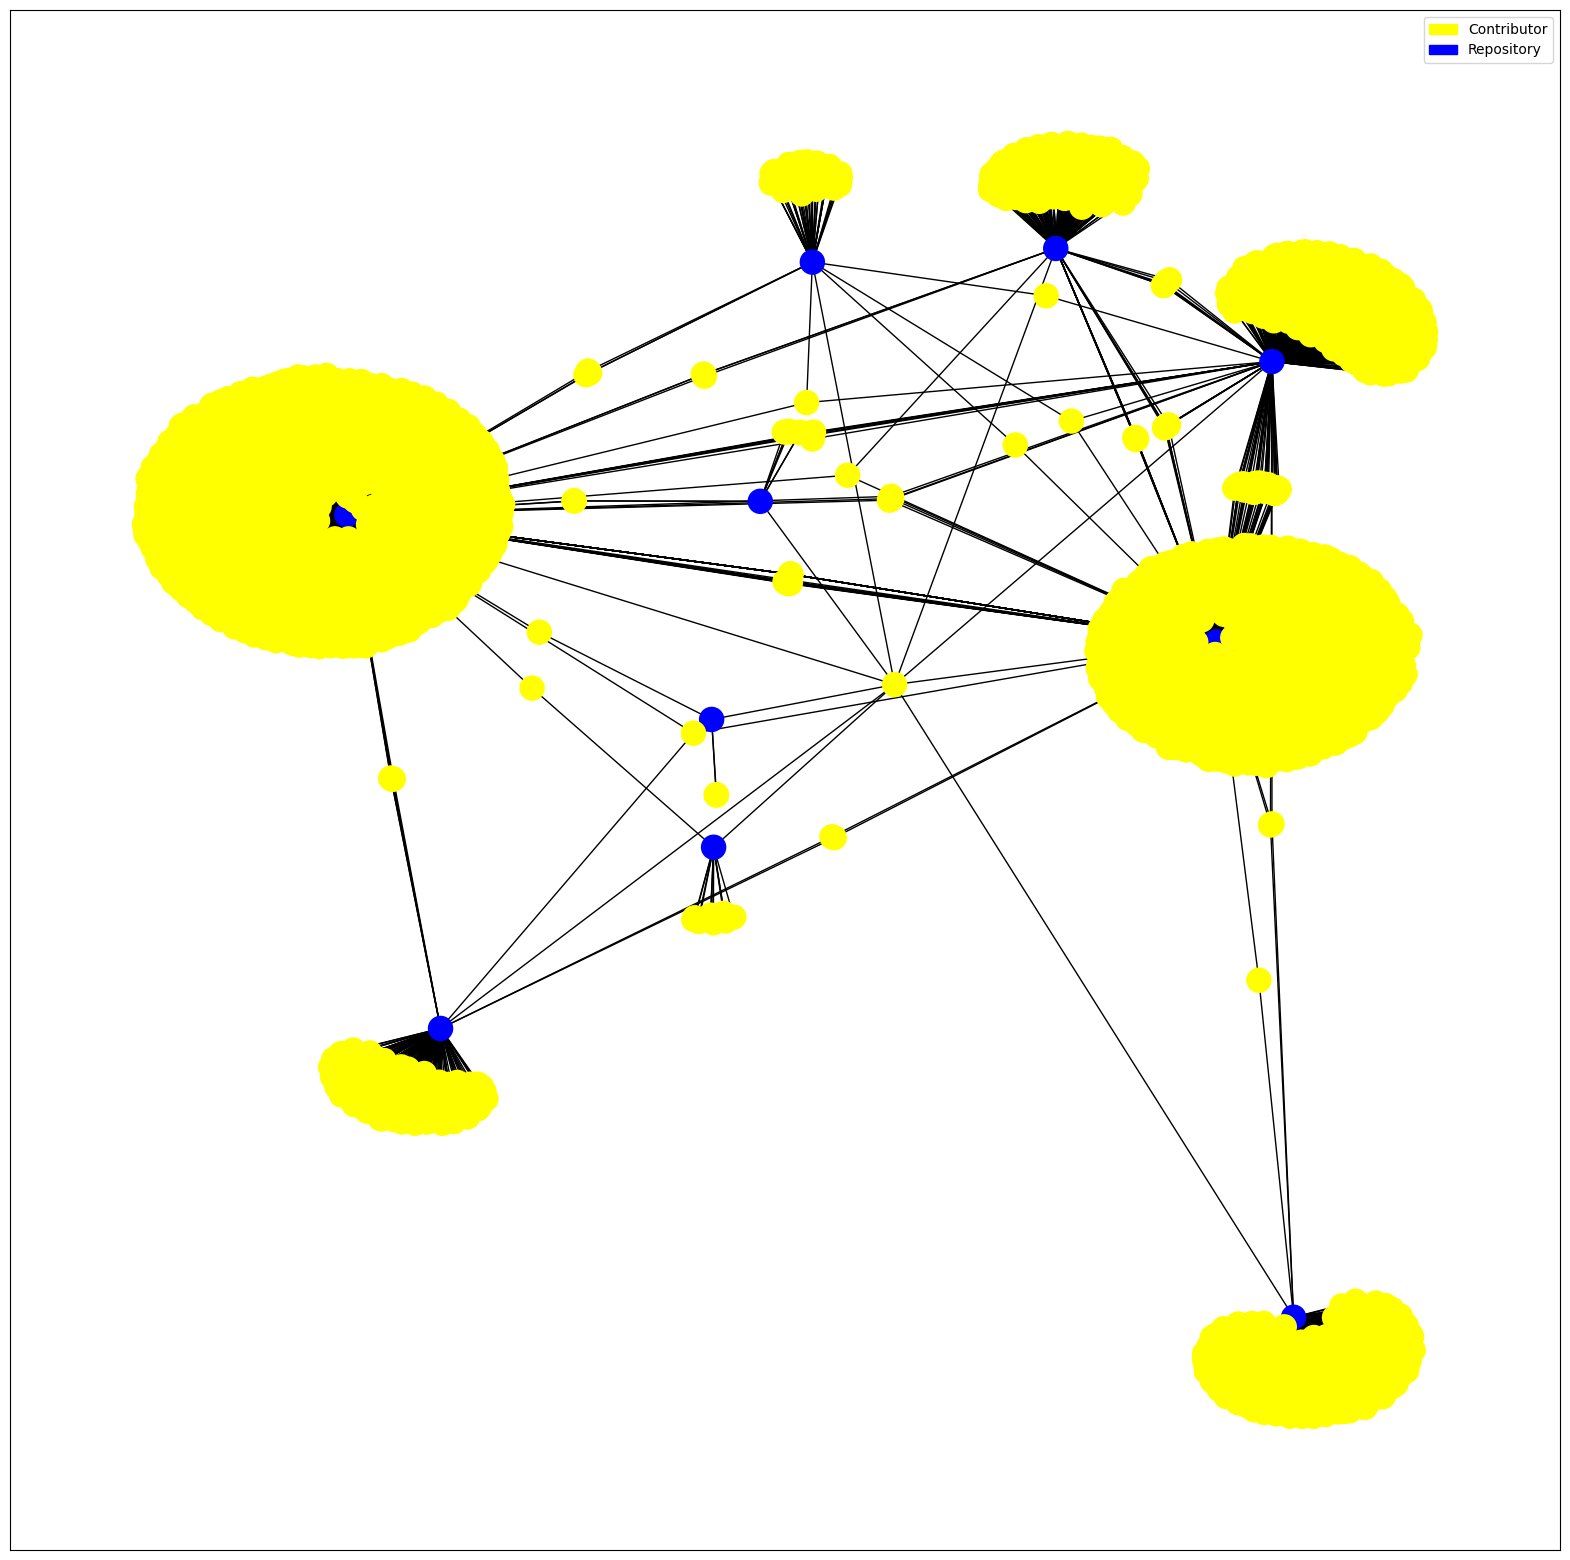

In [215]:
fig, ax = plt.subplots(figsize=(20,20))
yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
blue_patch = mpatches.Patch(color='blue', label='Repository')
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=False)

What we see above is a certain set of repositories and their contributors plotted on the same graph. The blue dots represent project repositories and the yellow dots represent their contributors. This gives us an idea of central projects which have a large number of contributors and how other projects are connected to them. However, just given the number of repositories, this graph is hard to dig into, so lets subset this graph to create a smaller plot.

In [216]:
#subsetting the first 50 repo nodes for a smaller plot
smaller_df_melted_commit = df_melted_commit[0:50]

Here, we narrow down the entire set of nodes into view only 50 nodes plotted on a graph. Note, this is just for visual simplicilty. This is not a logical filtering and not all contributors for a project are going to be seen on the same plot

In [217]:
G = nx.from_pandas_edgelist(smaller_df_melted_commit, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [218]:
nodes = G.nodes()
Repo_id = smaller_df_melted_commit['repo_name'].to_list()
contributor_id = smaller_df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

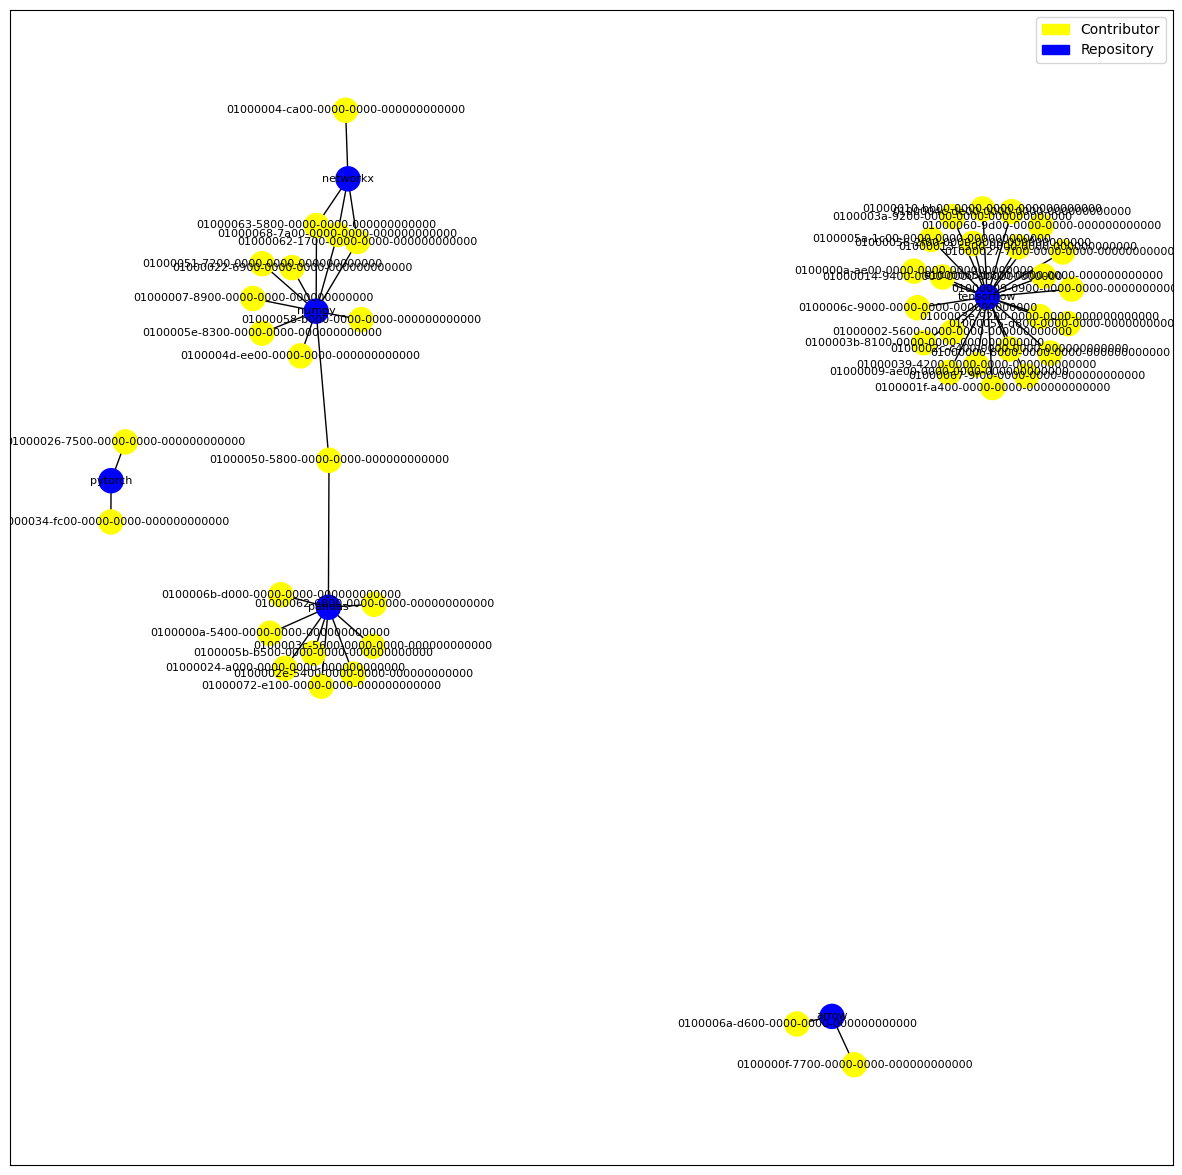

In [219]:
fig, ax = plt.subplots(figsize=(15,15))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=True)

In [220]:
issue_contrib

,repo_id,repo_name,repo_git,cntrb_id,issue_id
0,25495,numpy,https://github.com/numpy/numpy,None,52674
1,25495,numpy,https://github.com/numpy/numpy,None,52675
2,25495,numpy,https://github.com/numpy/numpy,None,48717
3,25495,numpy,https://github.com/numpy/numpy,None,45286
4,25495,numpy,https://github.com/numpy/numpy,None,43800
...,...,...,...,...,...
153342,25499,mlx,https://github.com/ml-explore/mlx,None,36286
153343,25499,mlx,https://github.com/ml-explore/mlx,None,36287
153344,25499,mlx,https://github.com/ml-explore/mlx,None,36288
153345,25499,mlx,https://github.com/ml-explore/mlx,None,35956


### Issue Contributor Graph

In [221]:
df_issue = issue_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_issue.head()

cntrb_id
repo_name


In [222]:
df_issue = df_issue.reset_index()
df_issue.head()

cntrb_id,repo_name


In [223]:
df_melted_issue = df_issue.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [224]:
df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]
df_melted_issue.head()

,repo_name,cntrb_id,number


In [225]:
Repo_id = df_melted_issue['repo_name'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [226]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [227]:
nodes = G.nodes()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

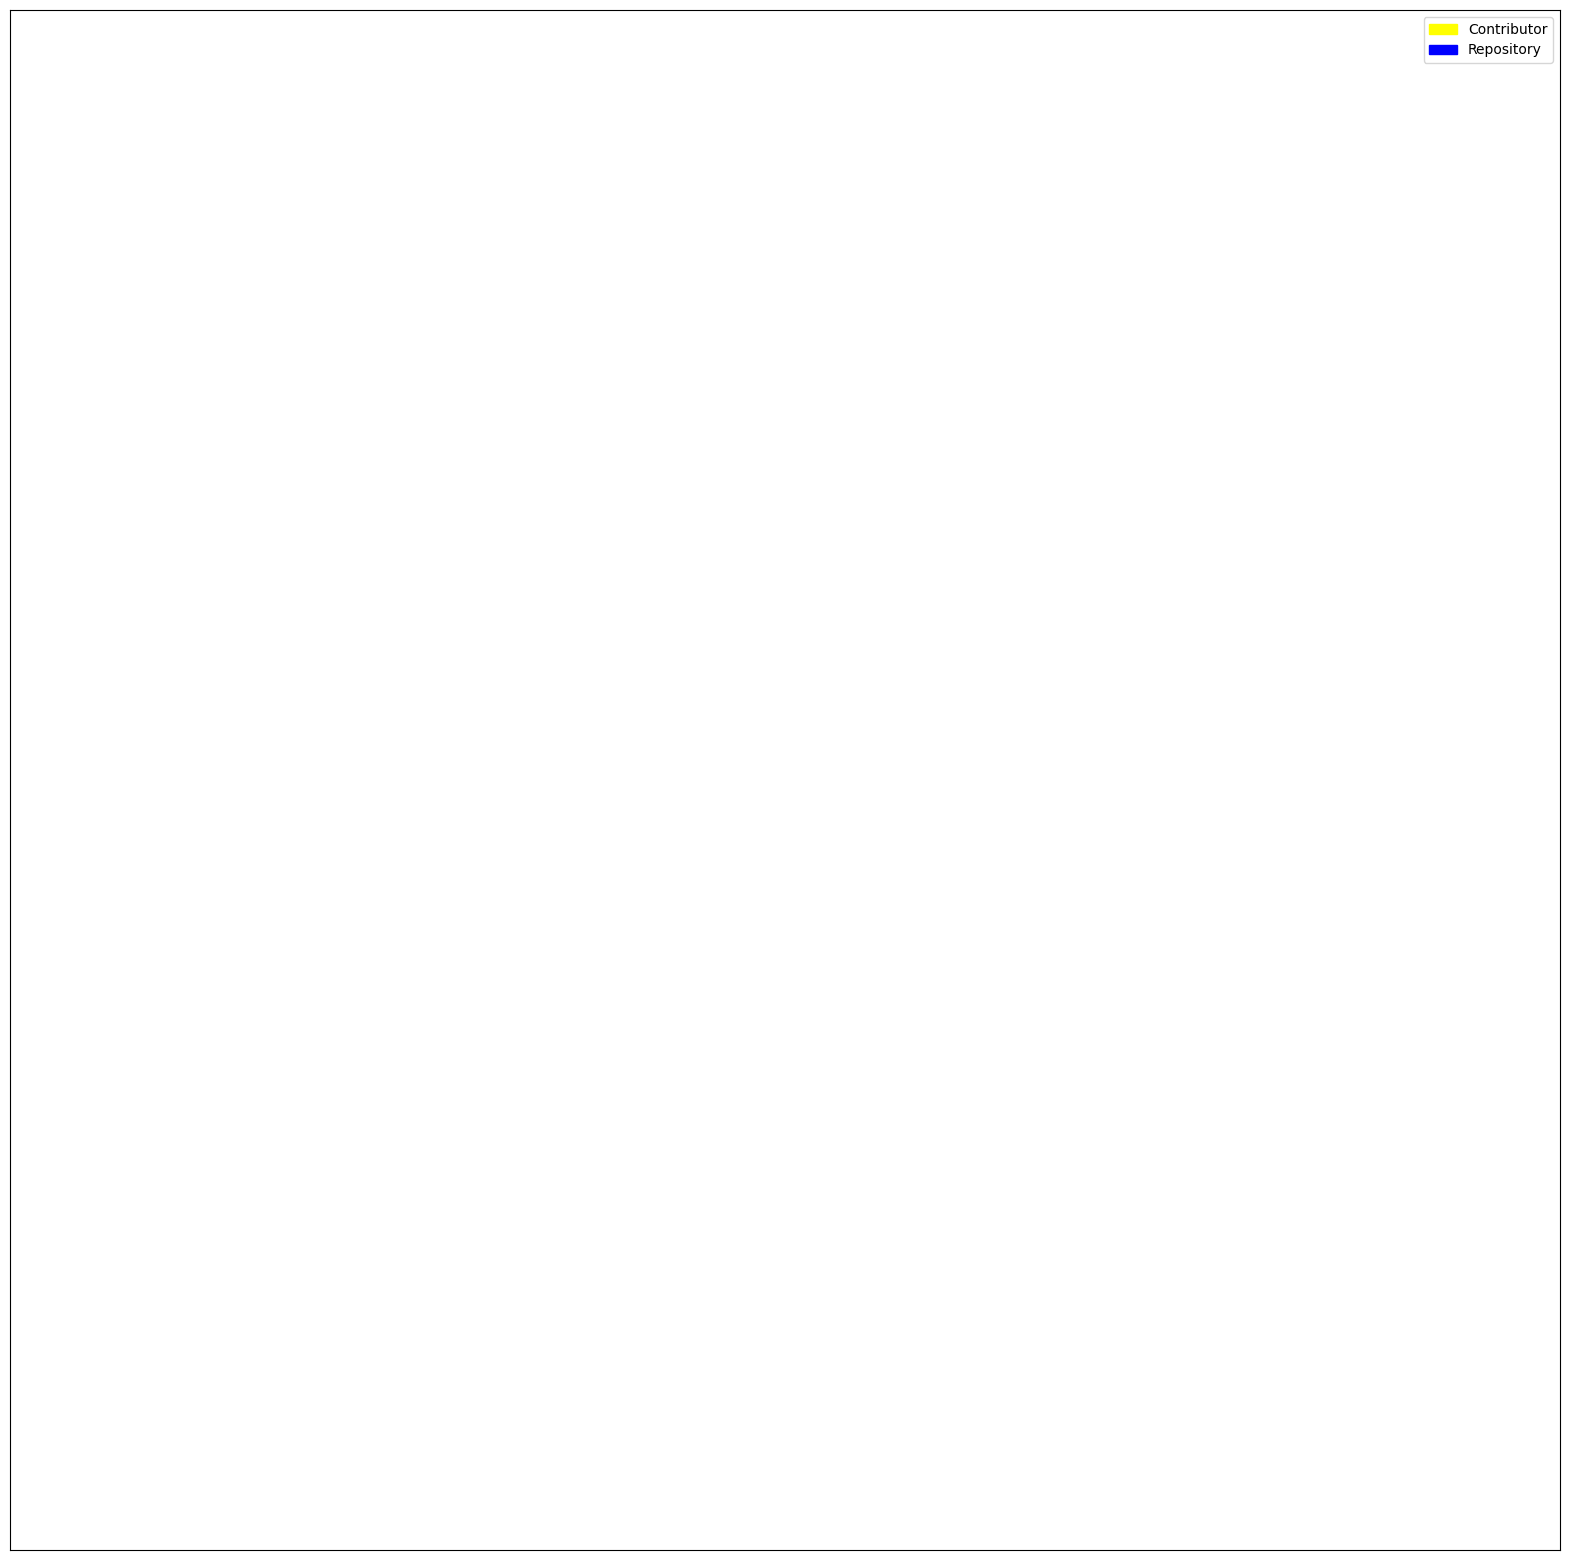

In [228]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### PR Contributor Graph

In [229]:
df_pr = pr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)
df_pr.head()

cntrb_id,01000002-3300-0000-0000-000000000000,01000004-6200-0000-0000-000000000000,01000004-c700-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000004-e100-0000-0000-000000000000,01000005-2200-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,01000006-8600-0000-0000-000000000000,01000006-af00-0000-0000-000000000000,01000006-cb00-0000-0000-000000000000,...,010a209b-dc00-0000-0000-000000000000,010a2202-0a00-0000-0000-000000000000,010a255f-e000-0000-0000-000000000000,010a2748-f000-0000-0000-000000000000,010a2a1a-0d00-0000-0000-000000000000,010a2aa0-dd00-0000-0000-000000000000,010a305c-e000-0000-0000-000000000000,010a5309-be00-0000-0000-000000000000,010a575b-dd00-0000-0000-000000000000,010a5a96-3d00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
numpy,0,0,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,2,0


In [230]:
df_pr = df_pr.reset_index()

In [231]:
df_melted_pr = df_pr.melt(
    ['repo_name'],
    var_name = 'cntrb_id',value_name='number')

In [232]:
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
df_melted_pr.head()

,repo_name,cntrb_id,number
0,arrow,01000002-3300-0000-0000-000000000000,52
18,tensorflow,01000004-6200-0000-0000-000000000000,1
25,pandas,01000004-c700-0000-0000-000000000000,3
33,networkx,01000004-ca00-0000-0000-000000000000,1
44,numpy,01000004-e100-0000-0000-000000000000,1


In [233]:
Repo_id = df_melted_issue['repo_name'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [234]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='repo_name',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [235]:
nodes = G.nodes()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

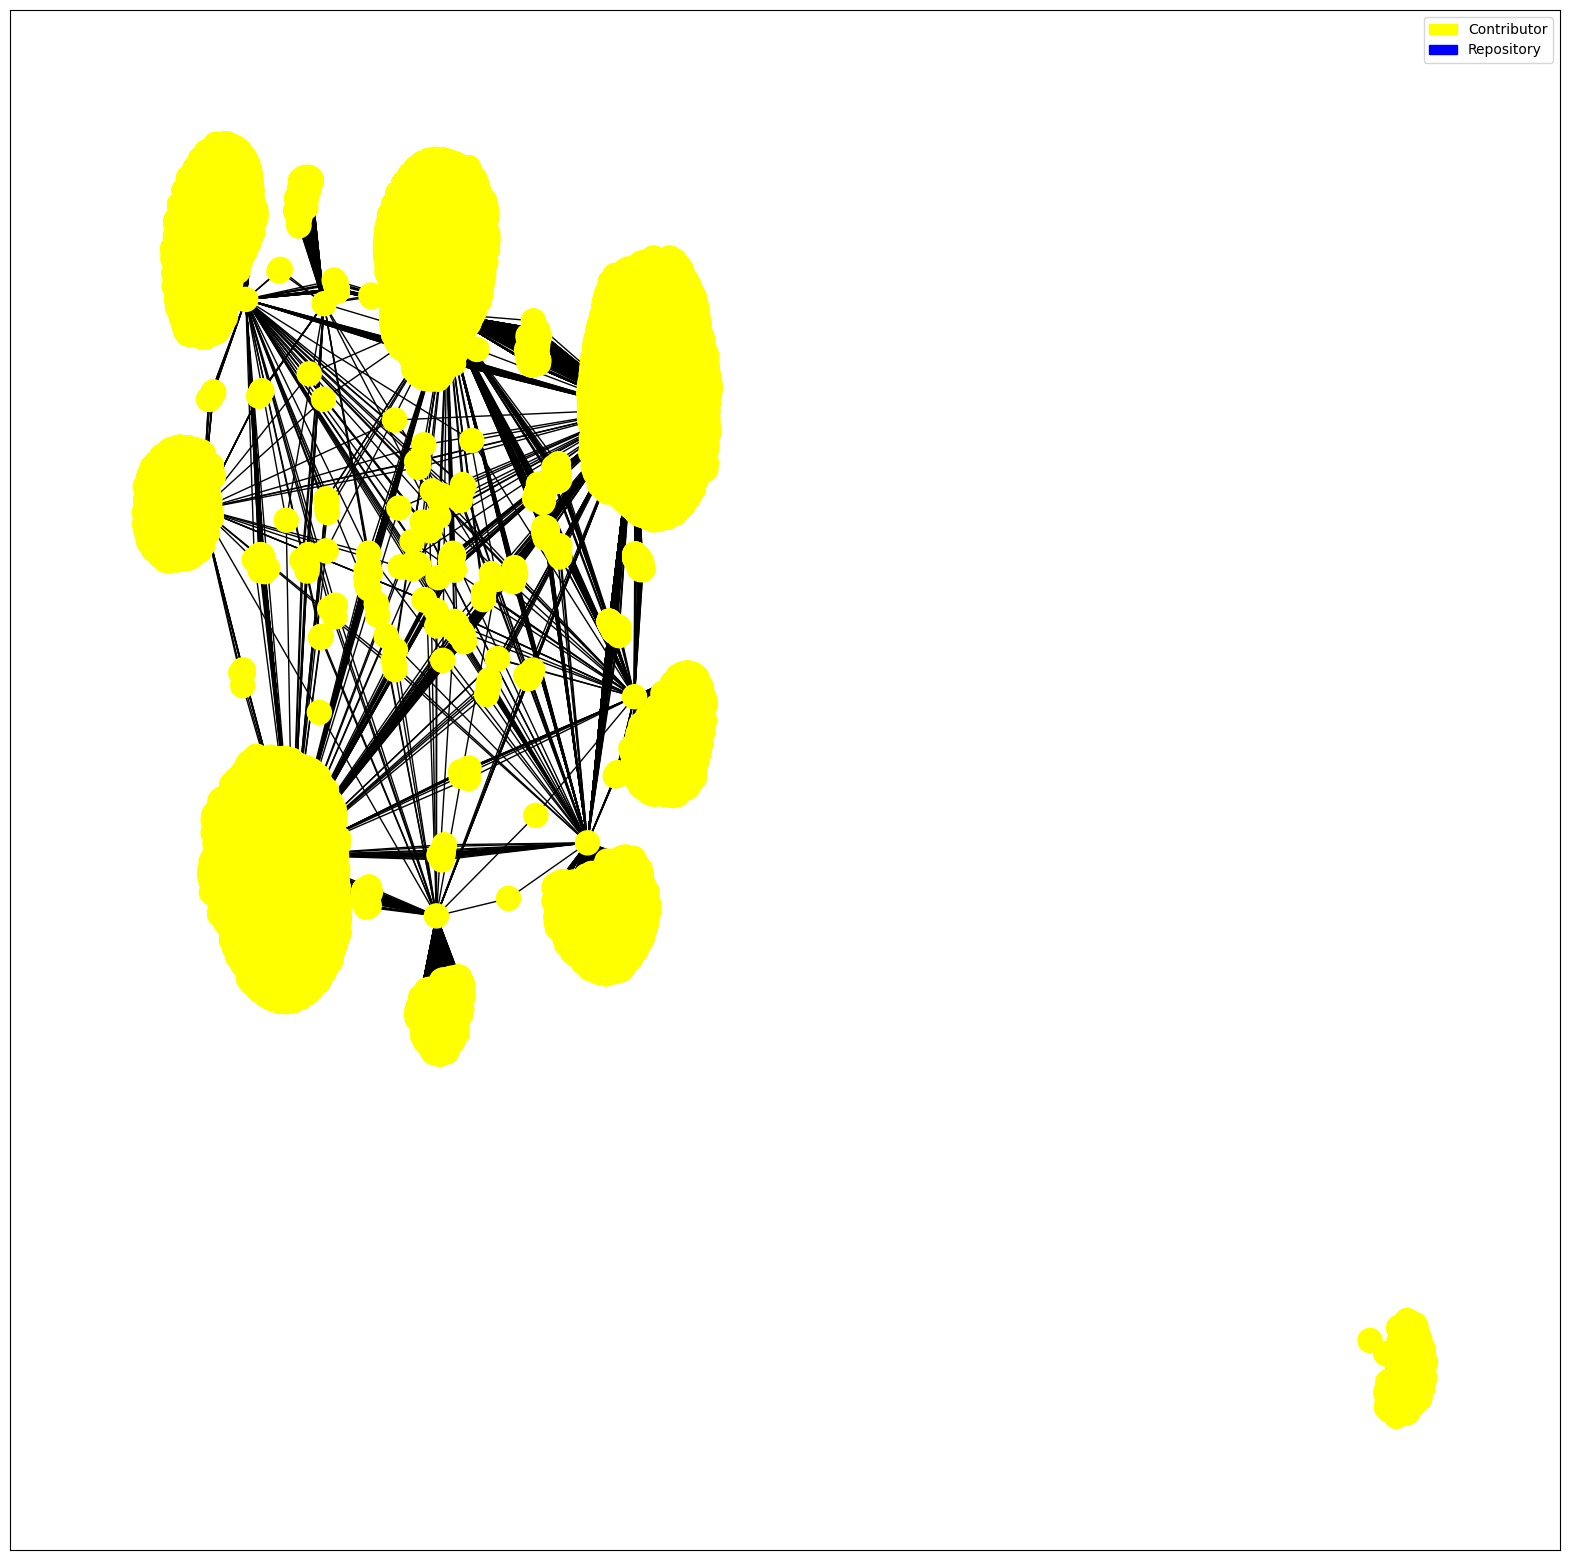

In [236]:
fig, ax = plt.subplots(figsize=(20,20))
ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax, with_labels=False)

## Nodes as projects edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [237]:
df_melted_pr.head()

,repo_name,cntrb_id,number
0,arrow,01000002-3300-0000-0000-000000000000,52
18,tensorflow,01000004-6200-0000-0000-000000000000,1
25,pandas,01000004-c700-0000-0000-000000000000,3
33,networkx,01000004-ca00-0000-0000-000000000000,1
44,numpy,01000004-e100-0000-0000-000000000000,1


In [238]:
contributorGraph = {}
for i, row in df_melted_pr.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['number'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_name'], row['number']))

In [239]:
list(contributorGraph.items())

[(UUID('01000002-3300-0000-0000-000000000000'), [('arrow', 52)]),
 (UUID('01000004-6200-0000-0000-000000000000'), [('tensorflow', 1)]),
 (UUID('01000004-c700-0000-0000-000000000000'), [('pandas', 3)]),
 (UUID('01000004-ca00-0000-0000-000000000000'), [('networkx', 1)]),
 (UUID('01000004-e100-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000005-2200-0000-0000-000000000000'), [('pytorch', 1)]),
 (UUID('01000006-8000-0000-0000-000000000000'), [('tensorflow', 2)]),
 (UUID('01000006-8600-0000-0000-000000000000'), [('tinygrad', 1)]),
 (UUID('01000006-af00-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000006-cb00-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000007-0400-0000-0000-000000000000'), [('pandas', 1)]),
 (UUID('01000007-2d00-0000-0000-000000000000'), [('tensorflow', 1)]),
 (UUID('01000007-8900-0000-0000-000000000000'), [('numpy', 1)]),
 (UUID('01000008-1700-0000-0000-000000000000'), [('tensorflow', 1)]),
 (UUID('01000009-0900-0000-0000-000000000000'), [('tensorfl

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [240]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor.items())

dict_items([(('arrow', 'pandas'), 6258), (('pandas', 'pytorch'), 312), (('pytorch', 'tinygrad'), 94), (('numpy', 'pandas'), 13490), (('pandas', 'tensorflow'), 853), (('keras-io', 'tensorflow'), 403), (('networkx', 'numpy'), 2091), (('arrow', 'tensorflow'), 140), (('networkx', 'tensorflow'), 32), (('networkx', 'pandas'), 435), (('arrow', 'networkx'), 79), (('pandas', 'tinygrad'), 10), (('numpy', 'tensorflow'), 608), (('pytorch', 'tensorflow'), 1868), (('arrow', 'numpy'), 3497), (('numpy', 'pytorch'), 823), (('arrow', 'pytorch'), 236), (('tensorflow', 'tinygrad'), 728), (('mlx', 'pandas'), 5), (('mlx', 'tensorflow'), 39), (('keras-io', 'pandas'), 40), (('arrow', 'mlx'), 40), (('keras-io', 'pytorch'), 38), (('networkx', 'tinygrad'), 17), (('arrow', 'keras-io'), 2), (('arrow', 'tinygrad'), 24), (('mlx', 'tinygrad'), 100), (('networkx', 'pytorch'), 42), (('mlx', 'networkx'), 2), (('keras-io', 'numpy'), 31), (('mlx', 'numpy'), 24), (('mlx', 'pytorch'), 12), (('keras-io', 'networkx'), 2), (('

`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [241]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

In [242]:
res

[('arrow', 'pandas', 6258),
 ('pandas', 'pytorch', 312),
 ('pytorch', 'tinygrad', 94),
 ('numpy', 'pandas', 13490),
 ('pandas', 'tensorflow', 853),
 ('keras-io', 'tensorflow', 403),
 ('networkx', 'numpy', 2091),
 ('arrow', 'tensorflow', 140),
 ('networkx', 'tensorflow', 32),
 ('networkx', 'pandas', 435),
 ('arrow', 'networkx', 79),
 ('pandas', 'tinygrad', 10),
 ('numpy', 'tensorflow', 608),
 ('pytorch', 'tensorflow', 1868),
 ('arrow', 'numpy', 3497),
 ('numpy', 'pytorch', 823),
 ('arrow', 'pytorch', 236),
 ('tensorflow', 'tinygrad', 728),
 ('mlx', 'pandas', 5),
 ('mlx', 'tensorflow', 39),
 ('keras-io', 'pandas', 40),
 ('arrow', 'mlx', 40),
 ('keras-io', 'pytorch', 38),
 ('networkx', 'tinygrad', 17),
 ('arrow', 'keras-io', 2),
 ('arrow', 'tinygrad', 24),
 ('mlx', 'tinygrad', 100),
 ('networkx', 'pytorch', 42),
 ('mlx', 'networkx', 2),
 ('keras-io', 'numpy', 31),
 ('mlx', 'numpy', 24),
 ('mlx', 'pytorch', 12),
 ('keras-io', 'networkx', 2),
 ('keras-io', 'mlx', 13),
 ('numpy', 'tinygrad',

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [243]:
g = nx.Graph()
g.add_weighted_edges_from(res)

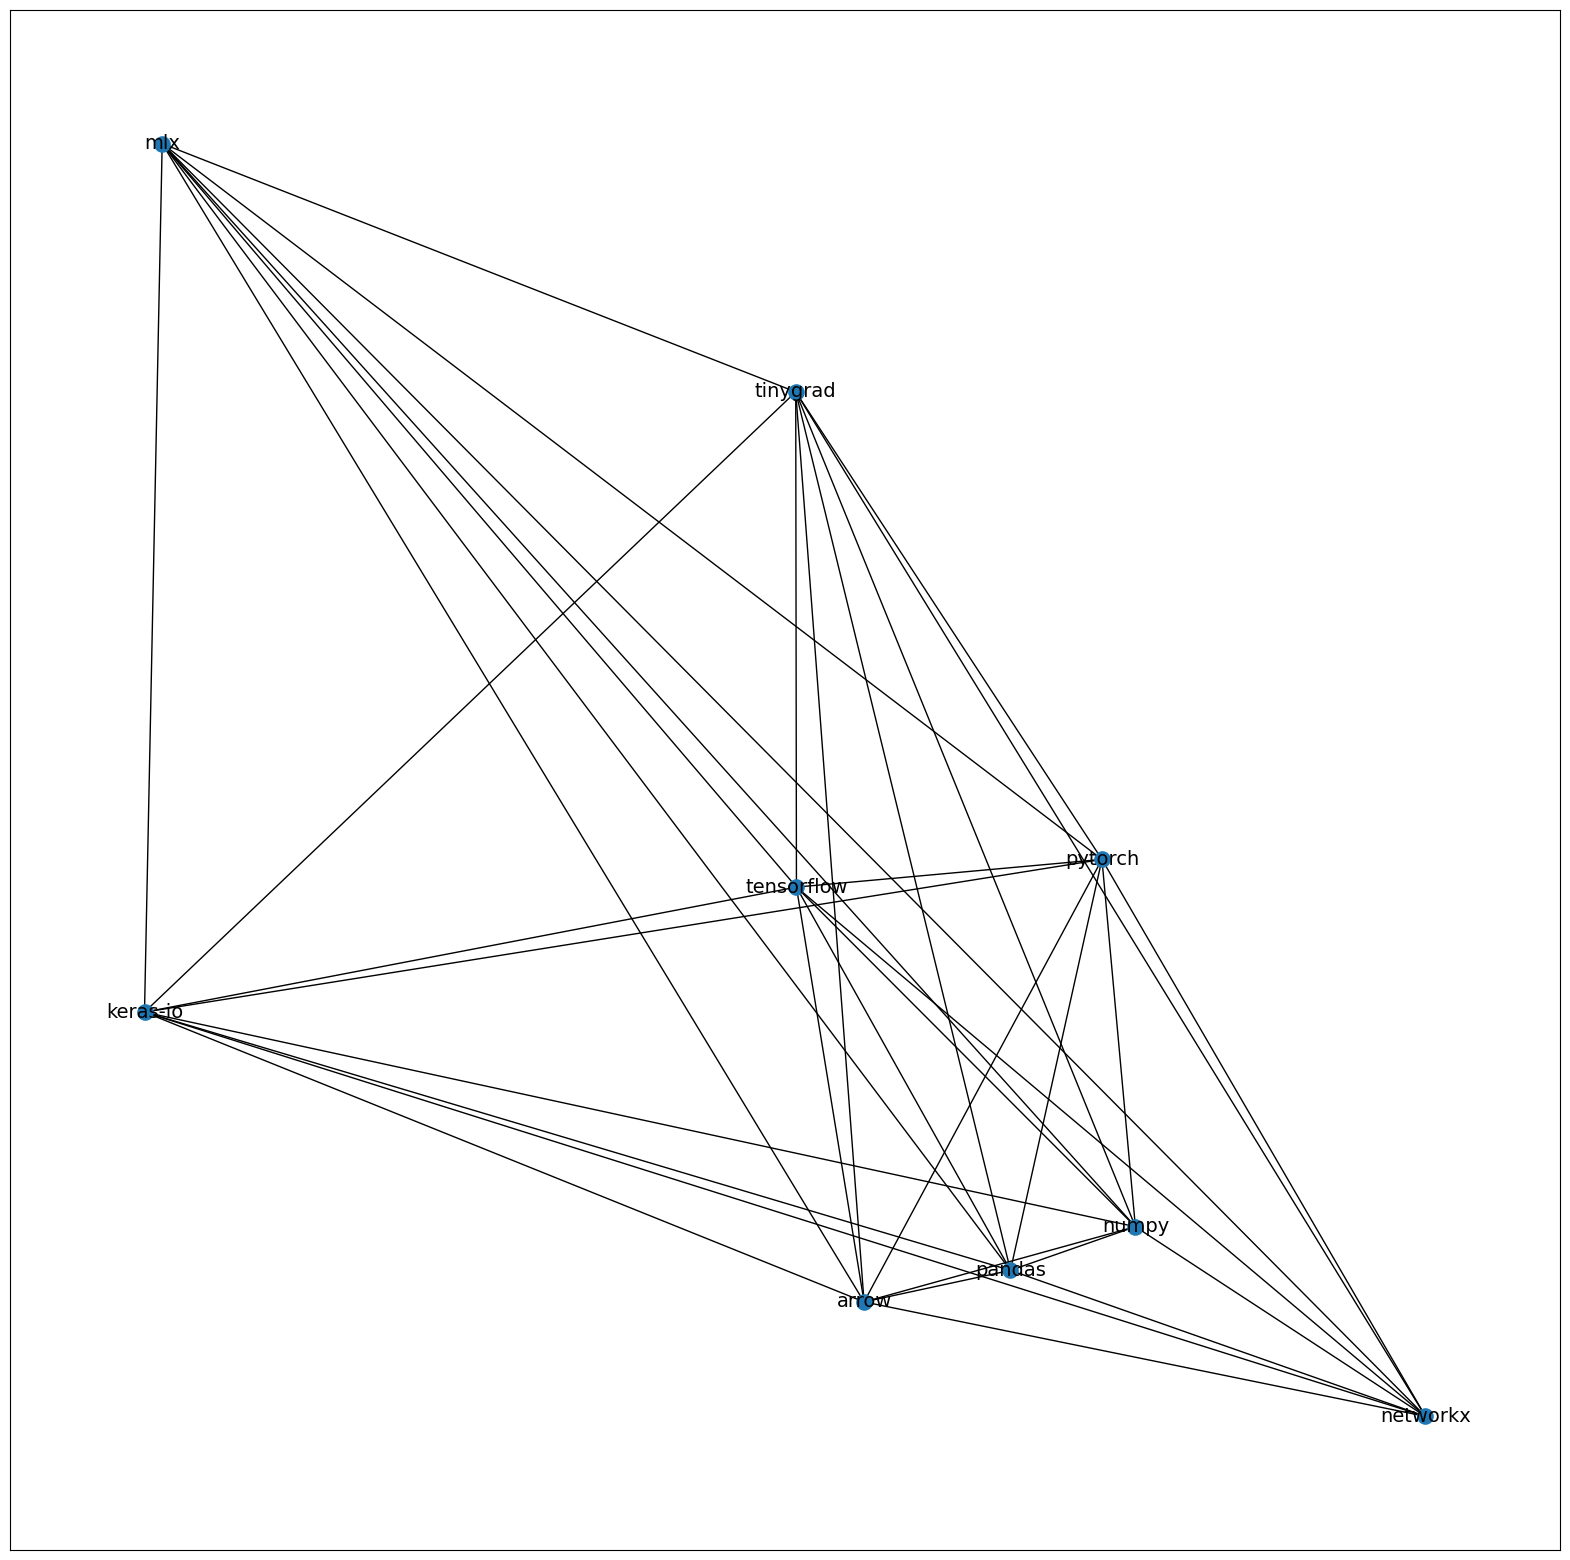

In [244]:
fig, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx(g, node_size=120, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.

In [245]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total execution time: {elapsed_time:.2f} seconds')


Total execution time: 325.76 seconds
